In [67]:
# config.py
from config import (
    ROSTER_SIZE,
    LEAGUE_SIZE,
    BONUS_PLAYER_POOL_MULT,
    G_SPLIT,
    W_SPLIT,
    B_SPLIT,
    SELECTED_COLUMNS,
    BREF_COLS,
    CORE_STATS,
    COLOR_PALETTE,
    FANTASYPROS_URL,
    NAME_OVERRIDES,
)

# data_io.py
from data_io import (
    load_or_generate_data,
)

# data_cleaning.py
from data_cleaning import (
    clean_name,
    clean_and_refine_nba_data,
)

# feature_engineering.py
from feature_engineering import (
    parse_awards_cell,
    calculate_fantasy_points,
    calculate_productivity_score,
    calculate_years_since_peak,
    create_metrics,
)

# modeling.py
from modeling import (
    split_data_nba,
    create_baseline_nba,
    attach_model_results,
    tune_xgb_nba,
    create_model_nba,
    build_prediction_frame,
)

# data_viz.py
from data_viz import (
    plot_feature_importance,
    plot_actual_vs_pred,
    plot_resid_vs_pred,
    plot_resid_hist,
    plot_recent_seasons,
    plot_decile_calib,
)

# Standard libraries and external dependencies
import pandas as pd
import numpy as np
import unicodedata
import os
import re
from hyperopt import hp
import requests
from bs4 import BeautifulSoup

# Create a data folder if not exists
if not os.path.exists('data'):
    os.makedirs('data')

In [68]:
# Setting input variables
START_YEAR = 2000
END_YEAR = 2024
PRED_YEAR = END_YEAR + 1

# Defining player pool sizes for each position group
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
g_pool = round(player_pool * G_SPLIT, 0)
w_pool = round(player_pool * W_SPLIT, 0)
b_pool = round(player_pool * B_SPLIT, 0)

In [69]:
api_df, bref_df = load_or_generate_data(START_YEAR, END_YEAR)

Loaded existing API data from CSV file.
Loaded existing BRef data from CSV file.


In [70]:
api_df = clean_and_refine_nba_data(api_df)
bref_df = clean_and_refine_nba_data(bref_df)

# Keep only selected columns for the model
api_df = api_df[SELECTED_COLUMNS]
bref_df = bref_df[BREF_COLS]

In [71]:
# Merging dataframes together
## Protip, "ws" values will be null for players that did not match correctly on name and year
combined_df = pd.merge(
    api_df,
    bref_df,
    on=["player_name_clean", "year"],
    how="left",
    suffixes=("", "_bref"),
)

# If duplicate columns appear in the dataset, keep only the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Drop rows where a player's team information is missing
combined_df = combined_df[combined_df["team"].notna()]

# Sort the dataframe by player name clean & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)

# Insert the team & ws columns to be placed after the year column for reference
combined_df.insert(
    combined_df.columns.get_loc("year") + 1,
    "team",
    combined_df.pop("team"),
)
combined_df.insert(
    combined_df.columns.get_loc("year") + 2,
    "ws",
    combined_df.pop("ws"),
)

In [72]:
# Calculating fantasy points for each season
combined_df = calculate_fantasy_points(combined_df)
# Calculating productivity score metrics
combined_df = calculate_productivity_score(combined_df, age_col='age')
# Calculating years since each player's peak season
combined_df = calculate_years_since_peak(combined_df)

In [73]:
awards_parsed = combined_df["awards"].apply(parse_awards_cell)

awards_df = pd.DataFrame(list(awards_parsed), index=combined_df.index)

combined_df = pd.concat([combined_df, awards_df], axis=1)

# Dropping the original Awards column
combined_df = combined_df.drop(columns=["awards"])

In [74]:
# Adding additional aggregated metrics for core statistics
combined_df = create_metrics(combined_df, CORE_STATS)

# Creating age based features
combined_df["years_in_league"] = combined_df["year"] - combined_df["rookie_year"]
combined_df["age_bucket"] = pd.cut(
    combined_df["age"],
    bins=[18, 22, 26, 30, 34, 45],
    labels=["rookie", "young", "prime", "veteran", "late"],
)

# Creating feature to identify COVID-impacted season
combined_df["covid_flag"] = np.where(combined_df["year"] == 2020, 1, 0)
# Creating feature to identify post-COVID season (2021) due to limited games in 2020
combined_df["post_covid_flag"] = np.where(combined_df["year"] == 2021, 1, 0)

# Add incomplete_career_history flag to identify players that are missing a full capture of playing history
combined_df["incomplete_career_history"] = (
    (combined_df["rookie_year"] < (START_YEAR))
    | (
        (combined_df["college"] == "NO COLLEGE")
        & (combined_df["age"] >= 25)
        & (combined_df["year"] == (START_YEAR + 1))
    )
).astype(int)
# Setting each player's incomplete_career_history flag to 1 if any season is marked as incomplete
combined_df["incomplete_career_history"] = (
    combined_df.groupby("player_name_clean")["incomplete_career_history"].transform("max")
)

# Creating feature to identify career eligble games played
combined_df["eligible_games_played"] = combined_df["career_gp"] / (82 * (combined_df["years_in_league"] + 1))
# Adding 3 year average of eligible games played to emphasize recent availability
combined_df["avg3yr_eligible_games_played"] = combined_df.groupby("player_name_clean")["eligible_games_played"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Creating a feature to indicate whether a player was significantly injured during a season
combined_df["injury_flag"] = np.where(
    (combined_df["gp"] < 60) & (combined_df["min_pg"] >= 15), 1, 0
)
# Adding a 3 year average of injury flag to indicate frequency of injuries
combined_df["avg3yr_injury_flag"] = combined_df.groupby("player_name_clean")["injury_flag"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
# Adding cumulative sum career total of injury seasons
combined_df["career_injury_seasons"] = combined_df.groupby("player_name_clean")["injury_flag"].cumsum()

# Adding feature that 


In [75]:
# Fixing up columns that need to be reformatted for modeling
# Converting college column to categorical variable
combined_df["college"] = combined_df["college"].astype("category")
combined_df["pos"] = combined_df["pos"].astype("category")
combined_df["team"] = combined_df["team"].astype("category")

In [76]:
# Displaying combined_df sorted by player name & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)
display(combined_df)

,player_id,player_name_clean,season,year,team,ws,age,pts,reb,ast,...,years_in_league,age_bucket,covid_flag,post_covid_flag,incomplete_career_history,eligible_games_played,avg3yr_eligible_games_played,injury_flag,avg3yr_injury_flag,career_injury_seasons
0,201166,aaron brooks,2007-08,2008,HOU,1.4,23.0,264,56,87,...,0.0,young,0,0,0,0.621951,0.621951,0,0.000000,0
1,201166,aaron brooks,2008-09,2009,HOU,3.6,24.0,894,157,238,...,1.0,young,0,0,0,0.798780,0.710366,0,0.000000,0
2,201166,aaron brooks,2009-10,2010,HOU,5.5,25.0,1604,215,434,...,2.0,young,0,0,0,0.865854,0.762195,0,0.000000,0
3,201166,aaron brooks,2010-11,2011,2TM,1.1,26.0,634,78,233,...,3.0,young,0,0,0,0.829268,0.831301,1,0.333333,1
4,201166,aaron brooks,2012-13,2013,2TM,0.8,28.0,376,80,114,...,5.0,prime,0,0,0,0.660569,0.785230,1,0.666667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9033,980,zydrunas ilgauskas,2006-07,2007,CLE,6.6,32.0,925,599,123,...,10.0,veteran,0,0,1,0.534368,0.489595,0,0.000000,1
9034,980,zydrunas ilgauskas,2007-08,2008,CLE,6.1,33.0,1029,682,104,...,11.0,veteran,0,0,1,0.564024,0.530358,0,0.000000,1
9035,980,zydrunas ilgauskas,2008-09,2009,CLE,5.6,34.0,838,490,64,...,12.0,veteran,0,0,1,0.581614,0.560002,0,0.000000,1
9036,980,zydrunas ilgauskas,2009-10,2010,CLE,2.5,35.0,474,345,48,...,13.0,late,0,0,1,0.595819,0.580486,0,0.000000,1


# Modeling

## Defining training & testing datasets

In [77]:
# Splitting the data into training, testing, and validation sets
X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = split_data_nba(combined_df, PRED_YEAR)

# Scaling is not explicitly required for tree-based models, but keeping the process for potential future use
# X_train, X_test, scaler = scale_numeric_train_test(X_train, X_test)

## Creating Baseline Model

In [78]:
# Generating baseline model and predictions to measure final model performance
baseline_model, baseline_pred = create_baseline_nba(X_train, X_test, y_train, y_test)

[Baseline] RMSE: 468.639
[Baseline] MAE:  359.479
[Baseline] R^2:  0.668


In [79]:
# Attach baseline model results to testing set for review
results = attach_model_results(X_test, baseline_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
6626,nikola jokic,2021-22,2022,4337.8,3842.4,4061.364746,218.96
5495,lebron james,2006-07,2007,3758.2,4170.9,4045.664551,-125.24
5018,kevin garnett,2001-02,2002,3961.2,4444.9,3943.425049,-501.47
5505,lebron james,2016-17,2017,3794.8,4436.3,3812.190430,-624.11
5621,luka doncic,2019-20,2020,3221.6,3331.9,3624.099854,292.20
...,...,...,...,...,...,...,...
3743,james jones,2015-16,2016,309.0,235.4,331.295502,95.90
7914,stacey augmon,2004-05,2005,427.8,212.1,327.885284,115.79
2633,earl barron,2007-08,2008,640.1,212.7,324.574371,111.87
23,aaron gray,2012-13,2013,328.1,254.2,306.804230,52.60


## Creating Final Model

In [106]:
# Building a prediction dataframe and feature predictions dataframe
pred_df, X_pred = build_prediction_frame(
    combined_df,
    pred_year=PRED_YEAR,
    feature_cols=feature_cols,
)

In [107]:
# Define Hyperopt search space for final model tuning
MAX_DEPTH_CHOICES = [3, 4, 5, 6]
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.15), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Tune Model
best_params = tune_xgb_nba(
    X_train,
    X_val,
    y_train,
    y_val,
    space=space,
    metric="rmse",
    evals=50,
    max_depth_choices=MAX_DEPTH_CHOICES,
)

final_model, final_pred = create_model_nba(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    final_params=best_params,
)

100%|██████████| 50/50 [00:21<00:00,  2.35trial/s, best loss: 455.68813121813935]
Best Parameters: {'learning_rate': 0.17634825601171825, 'max_depth': 4, 'subsample': 0.9437159876042549, 'colsample_bytree': 0.9108623117341788, 'colsample_bynode': 0.633527425357, 'min_child_weight': 6.2867577820393175, 'reg_lambda': 3.517124210731792, 'reg_alpha': 0.0004991236627998643, 'gamma': 0.08826139098961686}
Best iteration: 48
[Final tuned] RMSE: 458.800
[Final tuned] MAE:  353.316
[Final tuned] R^2:  0.693


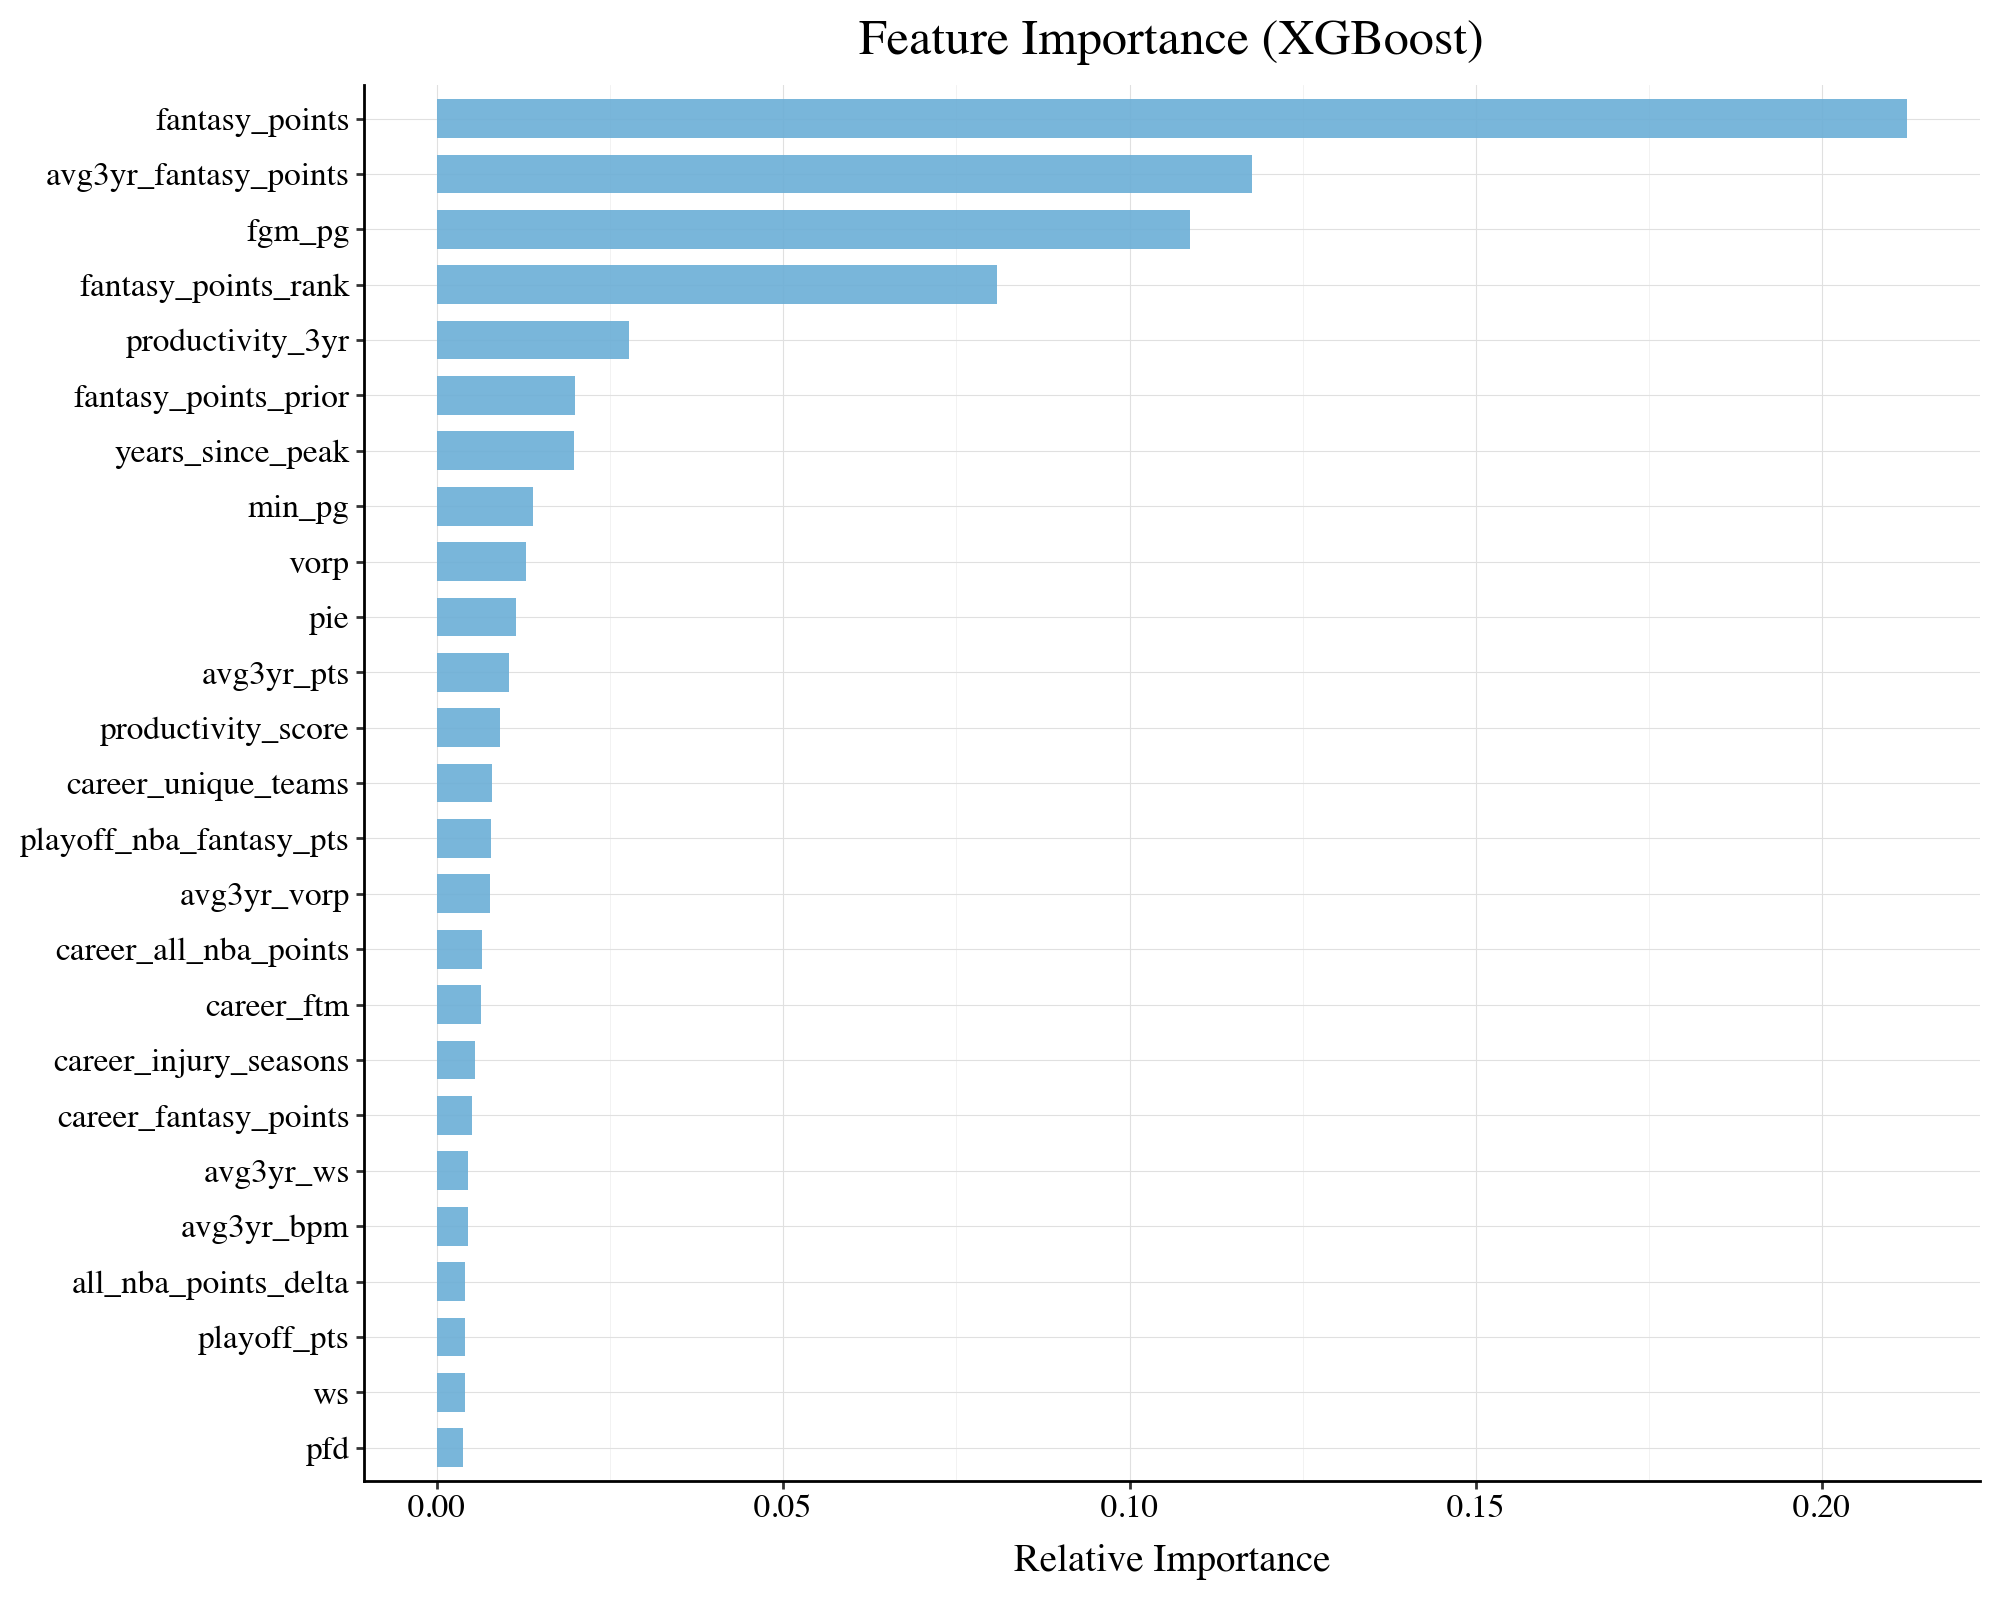

In [108]:
# Plotting out the feature importance of the final model
fi_plot = plot_feature_importance(
    final_model,
    X_train=X_train,  # your training feature frame
    top_n=25,
    importance_type="gain",
)
fi_plot.show()

In [109]:
# Attach final model results to validation set for review
results = attach_model_results(X_val, final_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
3712,james harden,2016-17,2017,4520.3,3815.8,4020.758301,204.96
3710,james harden,2014-15,2015,3936.3,4091.2,3970.297852,-120.90
5493,lebron james,2004-05,2005,4171.1,4233.7,3893.977783,-339.72
3120,giannis antetokounmpo,2022-23,2023,3450.9,4193.2,3803.174316,-390.03
5002,kevin durant,2009-10,2010,3883.1,3395.6,3745.631592,350.03
...,...,...,...,...,...,...,...
6781,pat burke,2002-03,2003,561.7,276.6,355.642914,79.04
7587,sam mitchell,2000-01,2001,590.1,431.9,337.705872,-94.19
8178,theo pinson,2019-20,2020,298.8,248.6,323.722626,75.12
3874,jason collins,2010-11,2011,279.4,122.6,321.922119,199.32


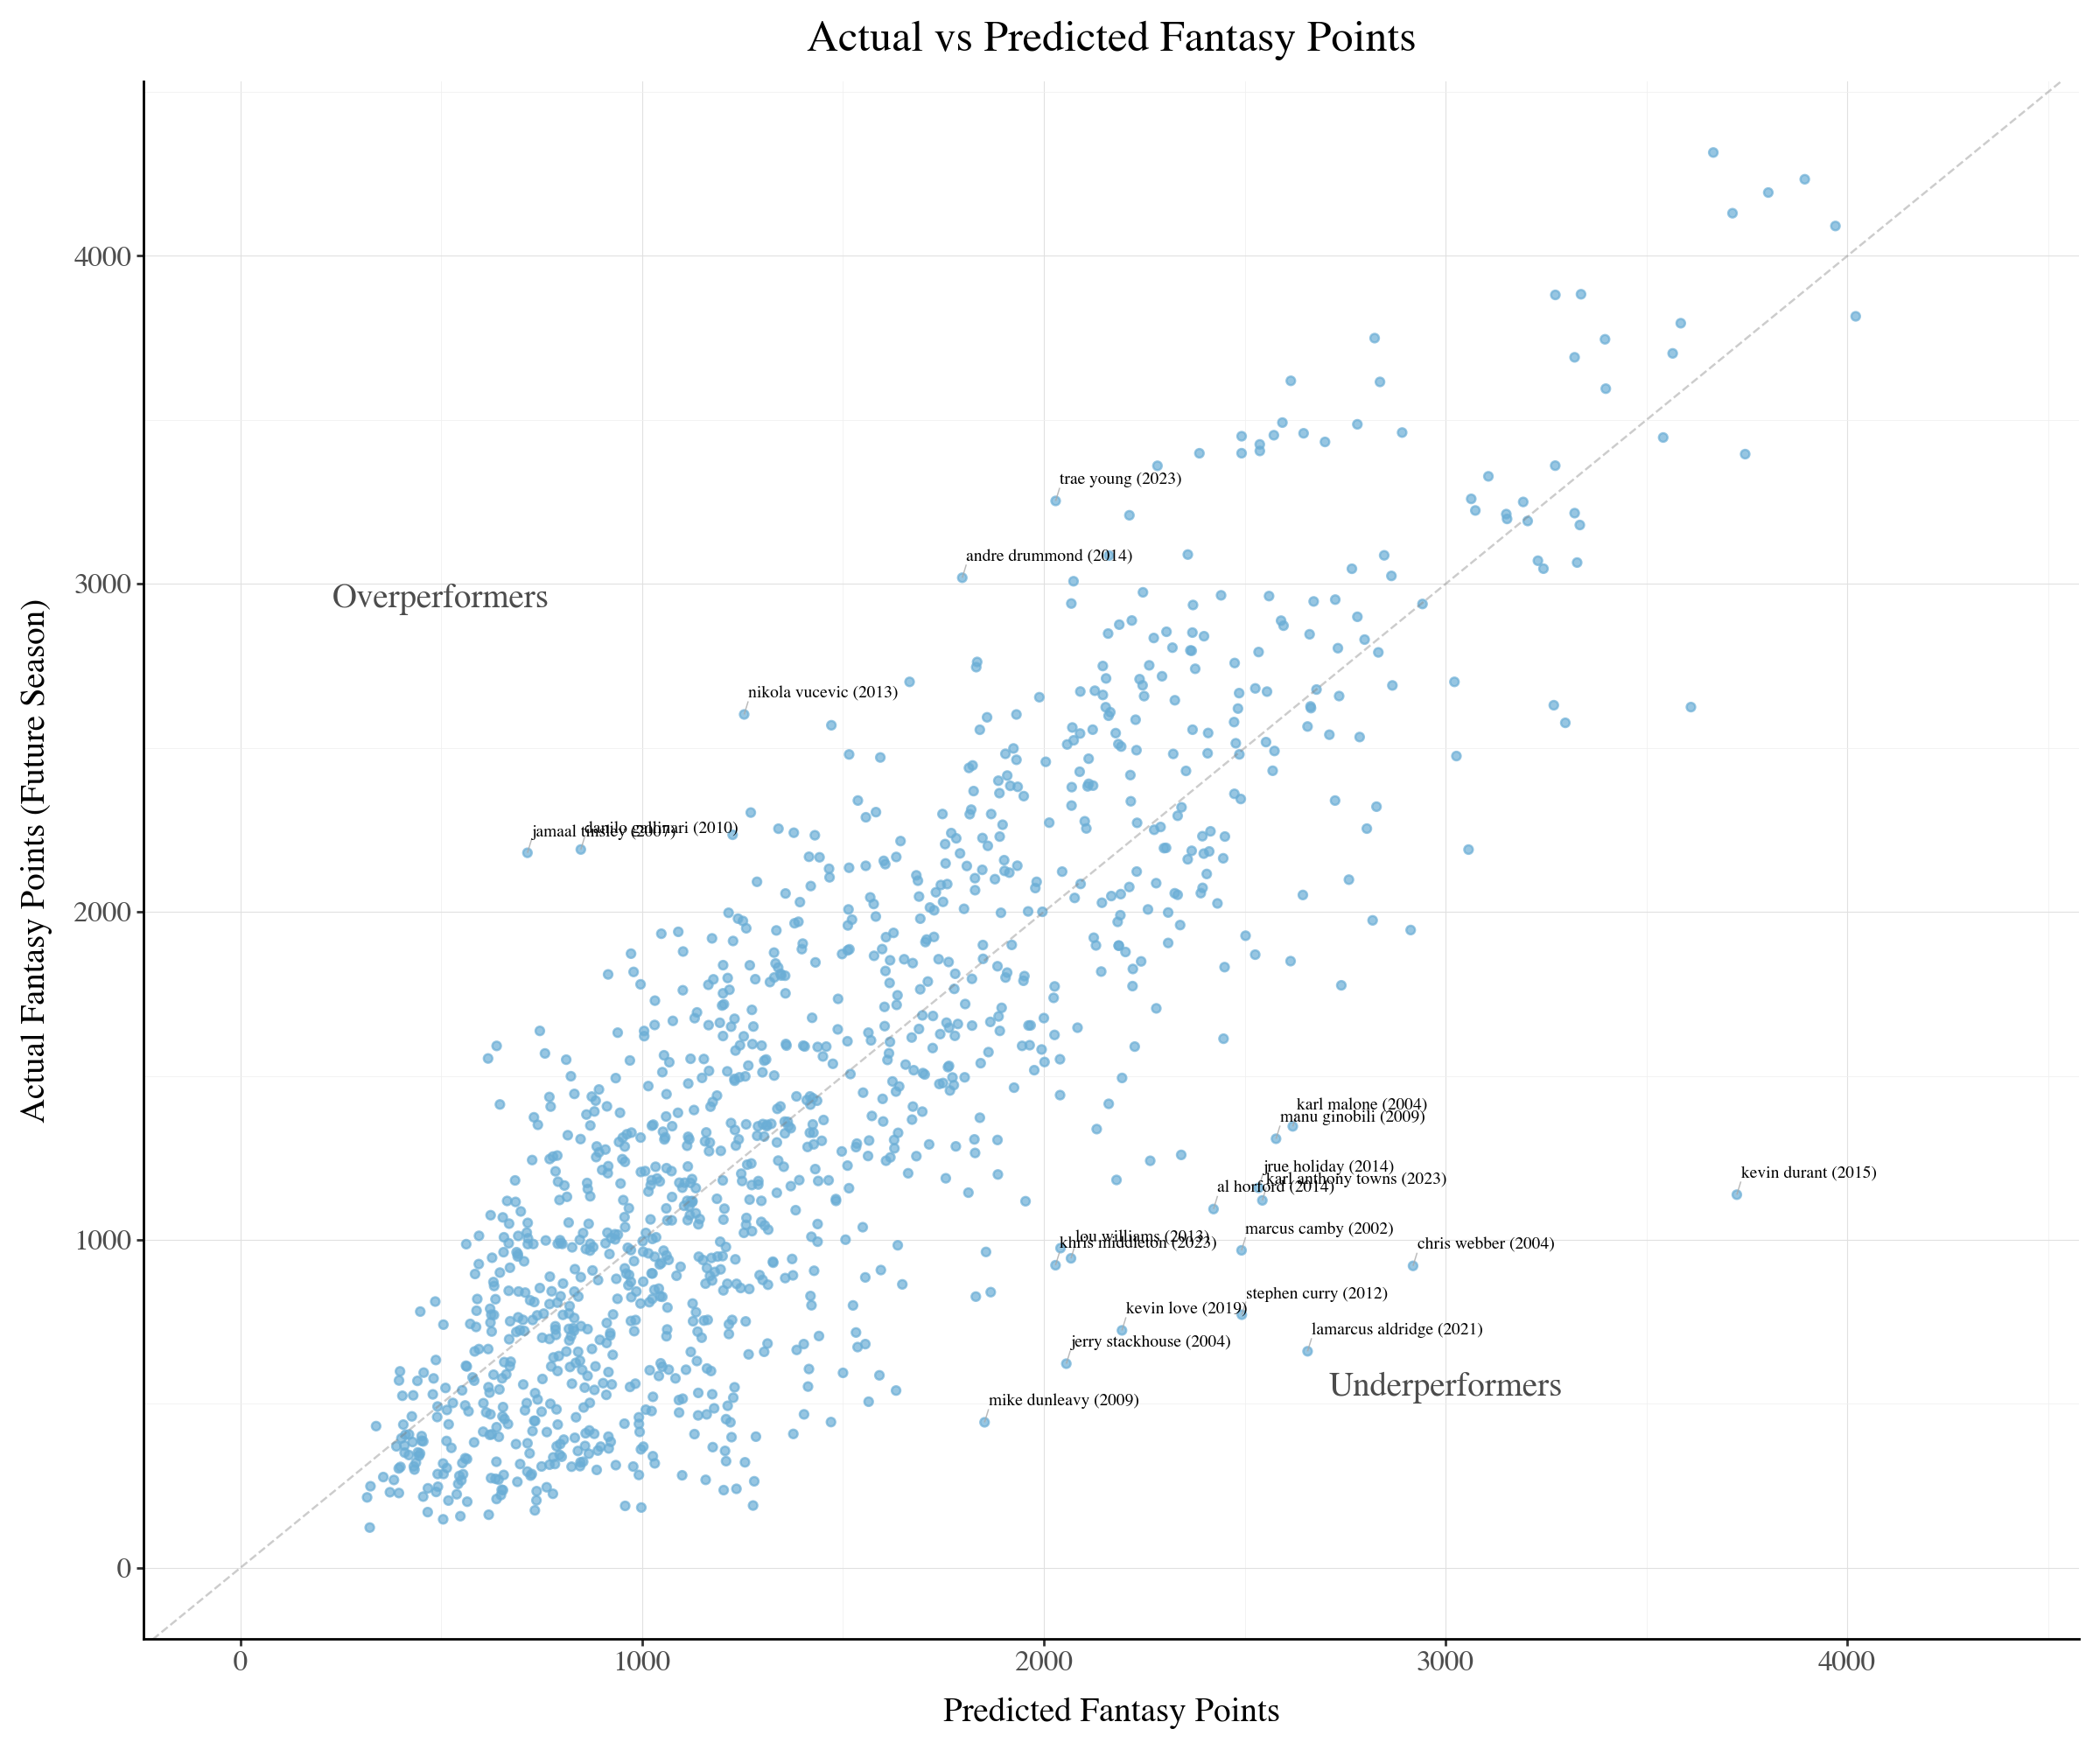

In [110]:
## Plot for Actual vs Predicted Fantasy Points
p = plot_actual_vs_pred(results, COLOR_PALETTE, top_n=20)
p.show()

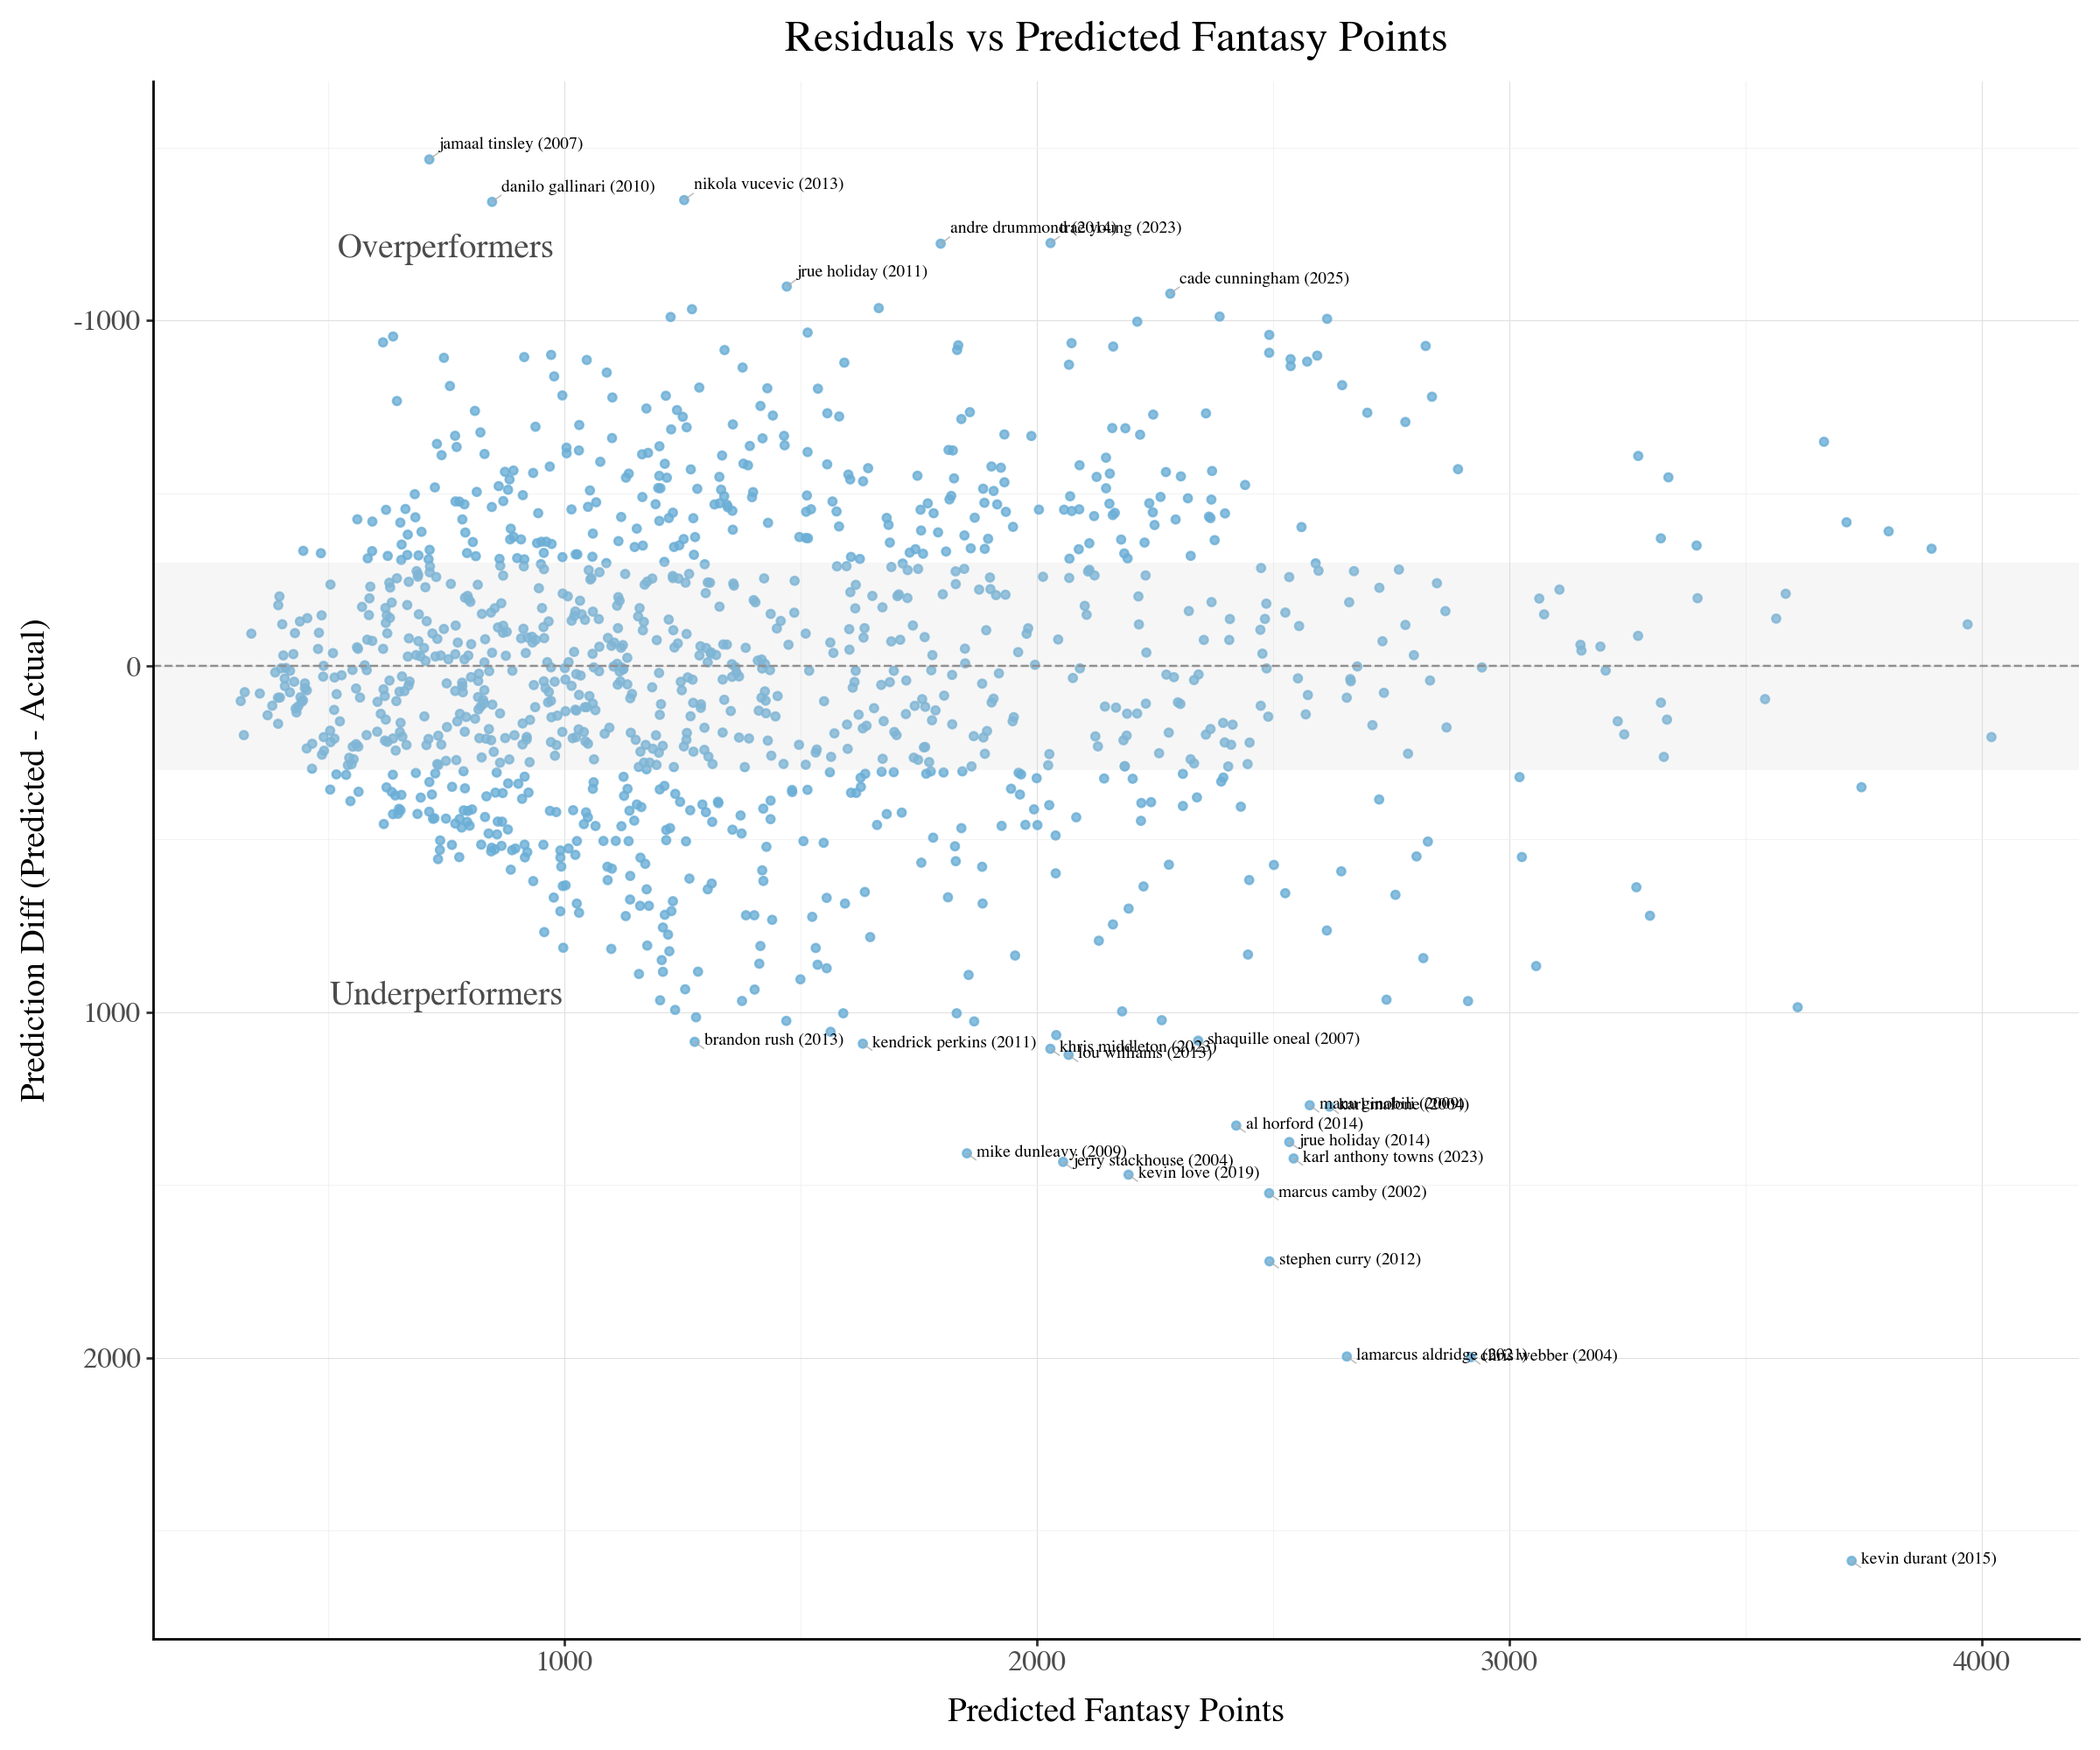

In [111]:
## Plot for Residuals vs Predicted Fantasy Points
p = plot_resid_vs_pred(results, COLOR_PALETTE, top_n=25)
p.show()


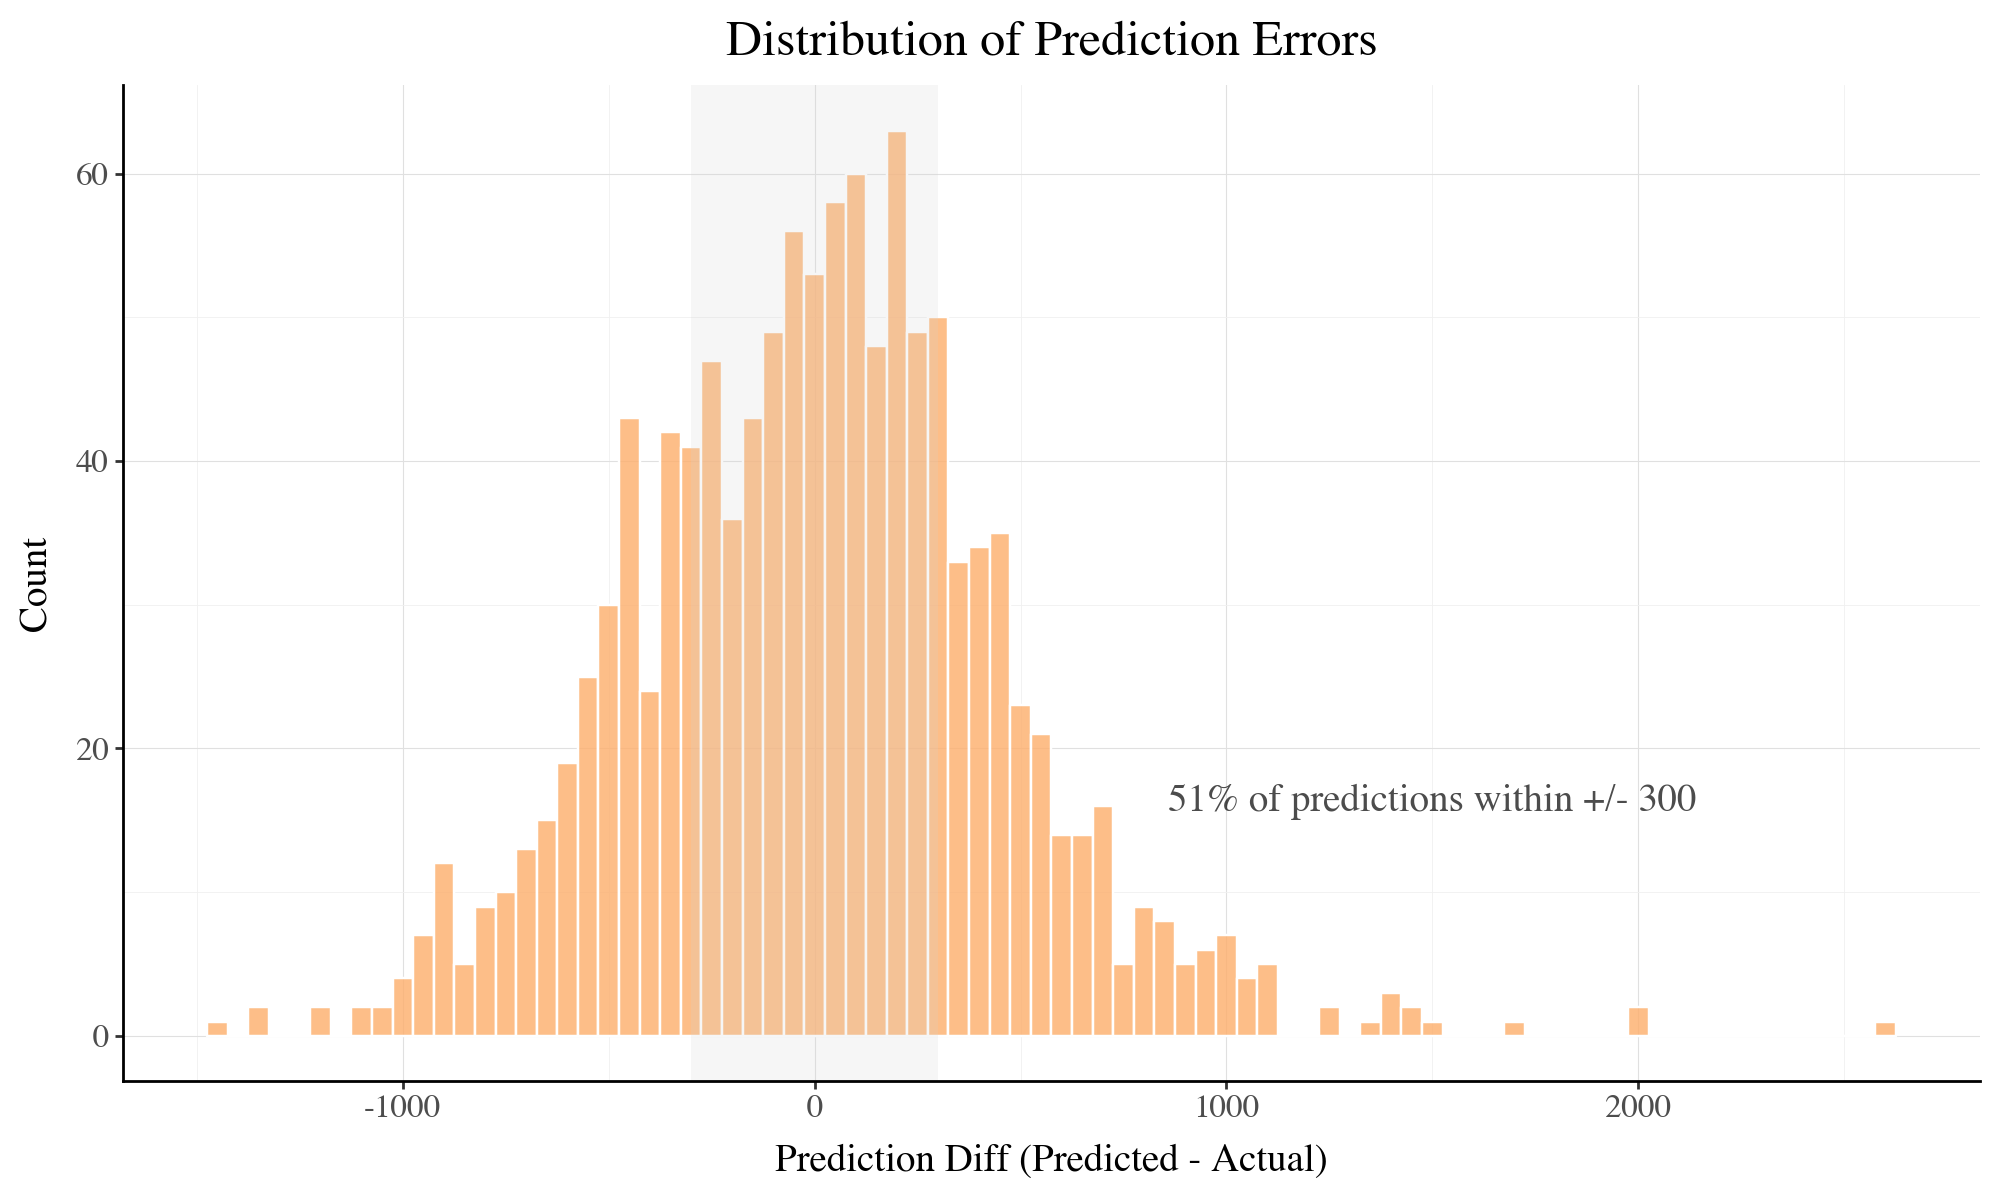

In [112]:
## Plot for Residuals Histogram
p = plot_resid_hist(results, COLOR_PALETTE, band=300)
p.show()

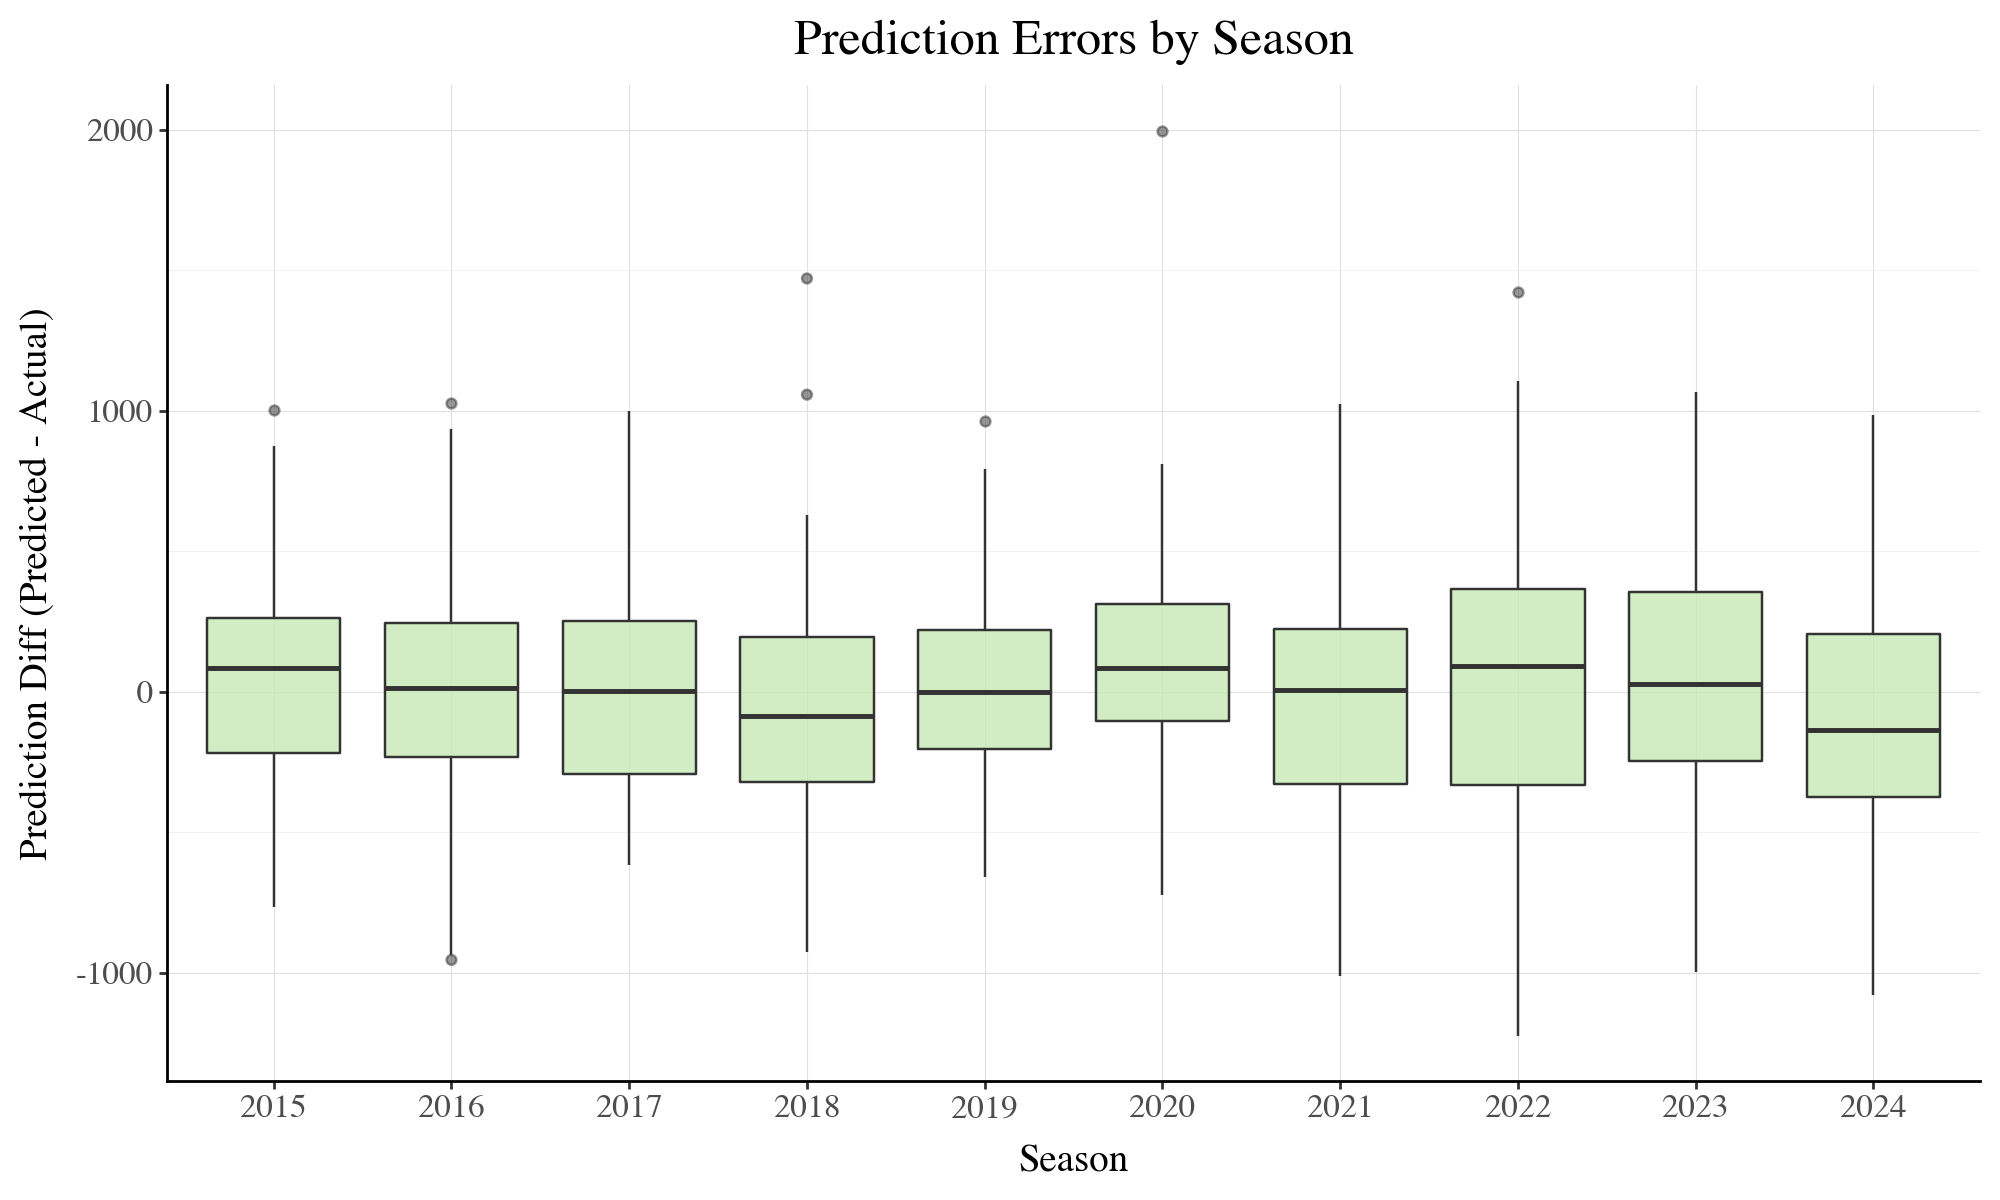

In [113]:
# Plotting prediction performance for the last 10 seasons
p = plot_recent_seasons(results, COLOR_PALETTE, n_seasons=10)
p.show()

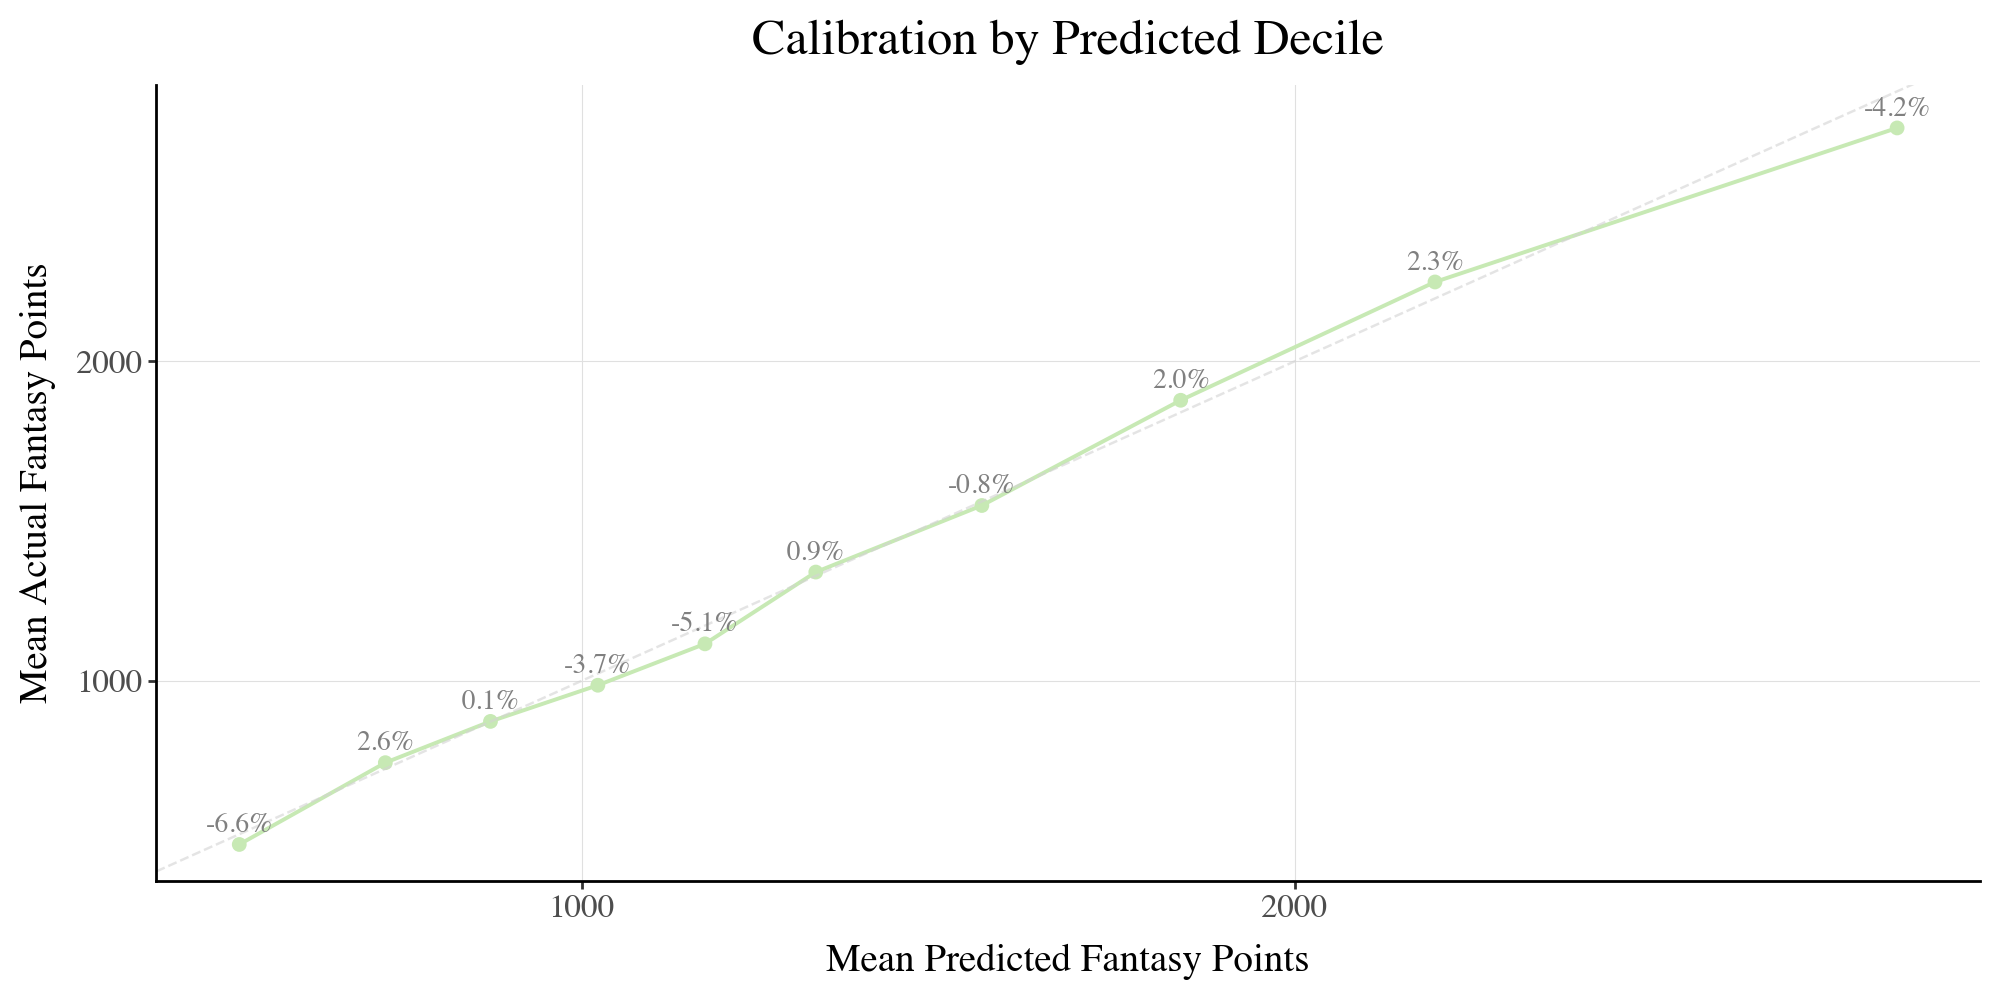

In [114]:
# Plotting performance by prediction decile
p = plot_decile_calib(results, COLOR_PALETTE)
p.show()

In [115]:
# Making final predictions & adding them back onto the prediction dataframe
pred_values = final_model.predict(X_pred)

pred_df["predicted_fantasy_points"] = pred_values
pred_df["predicted_rank"] = pred_df["predicted_fantasy_points"].rank(method="min", ascending=False).astype(int)


pred_eval_df = (pred_df[["player_name_clean", "fantasy_points", "predicted_fantasy_points", "fantasy_points_rank", "predicted_rank"]].sort_values(
        by="predicted_rank", ascending=True)
)

pred_eval_df['predicted_diff'] = (pred_eval_df['fantasy_points_rank'] - pred_eval_df['predicted_rank']).astype(int)

pred_eval_df = pred_eval_df[pred_eval_df['predicted_rank'] <= 250].reset_index(drop=True)

display(pred_eval_df)

,player_name_clean,fantasy_points,predicted_fantasy_points,fantasy_points_rank,predicted_rank,predicted_diff
0,nikola jokic,4501.4,3723.059326,1.0,1,0
1,shai gilgeous alexander,4108.8,3438.536865,2.0,2,0
2,giannis antetokounmpo,3845.1,3234.900391,3.0,3,0
3,luka doncic,2624.3,3142.127930,37.0,4,33
4,lebron james,3294.7,2832.031738,10.0,5,5
...,...,...,...,...,...,...
245,malaki branham,358.2,786.618958,391.0,246,145
246,delon wright,438.7,785.679199,369.0,247,122
247,paul reed,563.6,779.313477,329.0,248,81
248,bruce brown,755.8,778.081970,295.0,249,46


In [ ]:
# Write out final prediction evaluations to CSV
#  pred_eval_df.to_csv("nba_fantasy_predictions.csv", index=False)

In [117]:
## TODO: Revise the process to scrape fantasy pros as needed based on changes to their site structure
## TODO: Place functions for blending positions & pulling fantasypros data into relevant .py files
## TODO: Create player relative value metrics based on relative positional performance

In [118]:
# Creating function to assign position groups to players

def assign_position_group(df: pd.DataFrame):
    """
    Assigns a positional group based on the player's position.

    Parameters:
    df (pd.DataFrame): The DataFrame containing player data.
    position_col (str): The column name indicating the player's position.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'position_group' column.
    """
    # Define position group mappings, Designated Hitters will default as infielders

    position_mapping = {
        "G": {"PG", "SG"},
        "W": {"SF", "PF"},
        "B": {"C"},
    }

    def map_position(pos):
        for group, positions in position_mapping.items():
            if pos in positions:
                return group
        return np.nan  # Unexpected values are set to NaN

    # Apply mapping function
    df["position_group"] = df['pos'].apply(map_position)

    return df

In [119]:
# List of player names that should keep their suffixes for fantasypros join (fantasypros includes suffixes for some players seemingly at random)
HOLDOUT_SUFFIX_NAMES = {
    "daron holmes ii",
    "dereck lively ii",
    "gary payton ii",
    "ronald holland ii"
}

def remove_suffixes(name):
    name_clean = name.strip().lower()
    if name_clean in HOLDOUT_SUFFIX_NAMES:
        return name  # Return original name if in holdout group
    # Remove common suffixes at the end of the name
    return re.sub(r'\s+(jr|sr|ii|iii|iv)$', '', name, flags=re.IGNORECASE).strip()

In [120]:
def scrape_fp_projections(url: str = FANTASYPROS_URL) -> pd.DataFrame:
    """
    Scrape the FantasyPros NBA overall rankings table and return as a DataFrame.
    Uses requests + BeautifulSoup to find the table with id="data".
    """
    # Fetch the page with a browser-like User-Agent
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the main data table (FantasyPros consistently uses id="data" on these pages)
    table = soup.find("table", {"id": "data"})
    if table is None:
        raise ValueError("Could not find table with id='data' on FantasyPros page.")

    # Extract header cells
    thead = table.find("thead")
    header_cells = thead.find_all("th")
    headers = [th.get_text(strip=True) for th in header_cells]

    # Extract body rows
    tbody = table.find("tbody")
    rows = []
    for tr in tbody.find_all("tr"):
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        # Some rows may be empty / separators
        if cells:
            rows.append(cells)

    # Build DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df

In [121]:
def clean_name_fp(name: str) -> str:
    """
    Convert a FantasyPros player string into a normalized 'player_name_clean'-style string.
    Example: 'Nikola Jokic (DEN - C)' -> 'nikola jokic'
    """
    if not isinstance(name, str):
        return ""

    # Remove accents (é -> e, etc.)
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")

    # Remove everything after the last closing parenthesis
    last_paren = name.rfind(")")
    if last_paren != -1:
        name = name[: last_paren + 1]

    # Drop anything in parentheses, e.g., " (DEN - C)"
    name = re.sub(r"\s*\(.*?\)", "", name)

    # Collapse whitespace & lowercase
    name = re.sub(r"\s+", " ", name).strip().lower()

    # Apply prior clean_name process to name
    name = clean_name(name)

    return name

In [122]:
# Function to extract first position from FantasyPros player string
def _extract_first_position(player_str):
    m = re.search(r'\(([^)]+)\)', str(player_str))
    if m:
        parts = m.group(1).split('-')
        if len(parts) > 1:
            positions = parts[1].split(',')
            return positions[0].strip()
    return None

def prepare_fantasypros_df() -> pd.DataFrame:
    """
    Scrape FantasyPros overall rankings and produce a cleaned dataframe
    with a `player_name_clean` column ready to join.
    """
    fp_raw = scrape_fp_projections(FANTASYPROS_URL)

    # Normalize column names to snake_case
    fp = fp_raw.copy()
    fp.columns = (
        fp.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("%", "pct")
    )

    # FantasyPros normally has a 'player' column
    if "player" not in fp.columns:
        raise ValueError(
            f"'player' column not found in FantasyPros DF. Columns: {fp.columns.tolist()}"
        )

    # Create player_name_clean
    fp["player_name_clean"] = fp["player"].apply(clean_name_fp)

    # Extract first position from the player string
    fp["position"] = fp["player"].apply(_extract_first_position)

    # Apply your existing name overrides if you want alignment with other sources
    # (assumes NAME_OVERRIDES dict is already defined in your notebook)
    if "NAME_OVERRIDES" in globals():
        fp["player_name_clean"] = fp["player_name_clean"].replace(NAME_OVERRIDES)

    # Try to identify a rank column and standardize its name
    rank_col_candidates = [c for c in fp.columns if "rank" in c or c == "rk"]
    if rank_col_candidates:
        fp = fp.rename(columns={rank_col_candidates[0]: "fp_rank"})

    return fp

In [123]:
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3

def build_final_projections(merged_projections, MODEL_WEIGHT: float, PROJECTION_WEIGHT: float) -> pd.DataFrame:
    """
    Creates final blended projections by combining model predictions with site projections.

    Parameters:
        merged_projections (pd.DataFrame): DataFrame with 'predicted_fantasy_points' and 'projected_fantasy_points'.
        MODEL_WEIGHT (float): Weight for model predictions.
        PROJECTION_WEIGHT (float): Weight for site projections.

    Returns:
        pd.DataFrame: DataFrame with new 'final_projection' column.
    """
    df = merged_projections.copy()

    # Fill missing values in both columns from the other
    df["predicted_fantasy_points"] = df["predicted_fantasy_points"].fillna(df["projected_fantasy_points"])
    df["projected_fantasy_points"] = df["projected_fantasy_points"].fillna(df["predicted_fantasy_points"])

    # Weighted final projection
    df["final_projection"] = (
        df["predicted_fantasy_points"] * MODEL_WEIGHT +
        df["projected_fantasy_points"] * PROJECTION_WEIGHT
    )

    return df

In [124]:
# Removing suffixes from player names for joining with FantasyPros data
# Fantasypros does not include suffixes in player names
pred_df["player_name_clean"] = pred_df["player_name_clean"].apply(remove_suffixes)

In [125]:
fp_df = prepare_fantasypros_df()
fp_df.head()

,player,pts,reb,ast,blk,stl,fgpct,ftpct,3pm,to,gp,min,ftm,2pm,a/to,pf,player_name_clean,position
0,Shai Gilgeous-Alexander(OKC - PG),"1,182",165,236,25,53,.548,.891,74,71,37,"1,233",302,329,3.32,74,shai gilgeous alexander,PG
1,"Donovan Mitchell(CLE - PG,SG)","1,071",170,201,10,54,.495,.840,139,112,36,"1,218",184,235,1.79,93,donovan mitchell,PG
2,"Jaylen Brown(BOS - SG,SF)","1,062",232,181,13,36,.495,.779,79,135,36,"1,233",201,312,1.34,111,jaylen brown,SG
3,"Tyrese Maxey(PHI - PG,SG)","1,043",152,234,31,64,.476,.874,127,87,34,"1,346",188,237,2.69,72,tyrese maxey,PG
4,"Deni Avdija(POR - PF,SF,SG)","1,018",279,272,23,32,.467,.801,91,151,39,"1,376",309,218,1.80,109,deni avdija,PF


In [126]:
# Assigning a random value between 900 and 1100 for testing purposes
fp_df['projected_fantasy_points'] = np.random.randint(900, 1100, size=len(fp_df))

In [127]:
# Merging model predictions with fantasy pros projections
merged_projections = pd.merge(
    pred_df,
    fp_df[["player_name_clean", "projected_fantasy_points", "position"]],
    on="player_name_clean",
    how="outer",
)

# Replacing any missing "pos" values with "position" from fantasy pros
merged_projections["pos"] = merged_projections["pos"].astype(str)
merged_projections["pos"] = merged_projections["pos"].replace("nan", np.nan)
merged_projections["pos"] = merged_projections["pos"].fillna(merged_projections["position"])

In [128]:
# Creating final projections by blending model and fantasy pros projections
blended_df = build_final_projections(
    merged_projections,
    MODEL_WEIGHT,
    PROJECTION_WEIGHT,
)

# # Assign position groups to players
blended_df = assign_position_group(blended_df)

# Dropping rows where "position_group" is NaN, these are generally G-League or non-roster players
blended_df = blended_df[blended_df["position_group"].notna()]

# Ranking each player in their position group based on final blended projection
blended_df["position_rank"] = (blended_df.groupby("position_group")["final_projection"] 
    .rank(method="min", ascending=False).astype(int)
)

# Creating draft board based on position group pools
g_board = blended_df[(blended_df["position_group"] == "G") & (blended_df["position_rank"] <= g_pool)]
w_board = blended_df[(blended_df["position_group"] == "W") & (blended_df["position_rank"] <= w_pool)]
b_board = blended_df[(blended_df["position_group"] == "B") & (blended_df["position_rank"] <= b_pool)]

draft_df = pd.concat([g_board, w_board, b_board]).reset_index(drop=True)

In [129]:

POS_DAMPENING_MAP = {
    "G": 1.00,    
    "W": 1.00,   
    "B": 1.00,   
}

def apply_position_dampening(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    value_col: str = "relative_value",
    dampening_map: dict[str, float] | None = None,
    adjustment_col: str = "pos_adjustment",
) -> pd.DataFrame:
    """
    Apply position-based dampening multipliers to a value column.

    This is intended to reduce or increase the influence of certain position groups
    on final rankings (e.g., to avoid model-driven over-inflation of one group).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing position groups and a value column.
    position_col : str, default "position_group"
        Column containing the position grouping (e.g., "IF", "OF", "P", "C").
    value_col : str, default "relative_value"
        Column containing the pre-dampened value metric to adjust.
    dampening_map : dict[str, float] | None, default None
        Mapping from position group -> multiplier. Unspecified groups default to 1.0.
        Example: {"P": 0.85, "C": 0.95, "IF": 1.05, "OF": 1.10}
    adjustment_col : str, default "pos_adjustment"
        Name of the multiplier column to create (kept for transparency).

    Returns
    -------
    pd.DataFrame
        Copy of `df` with `adjustment_col` and dampened `value_col`.
    """
    out = df.copy()

    if dampening_map is None:
        dampening_map = {}

    out[adjustment_col] = out[position_col].map(dampening_map).fillna(1.0).astype(float)
    out[value_col] = out[value_col] * out[adjustment_col]

    return out

def calculate_relative_value(
    df: pd.DataFrame,
    *,
    position_col: str = "position_group",
    projection_col: str = "final_projection",
    vorp_cutoff: float = 0.66,
    z_weight: float = 0.50,
    vorp_weight: float = 0.50,
    vorp_scale: float = 1,
    dampening_map: dict[str, float] | None = None,
) -> pd.DataFrame:
    """
    Compute an NFL-style Relative Value metric for MLB using:
      - Z-score scaled projection within each position group
      - VORP (Value Over Replacement Player) within each position group
      - optional position dampening multipliers

    This assumes the player pool has *already* been filtered to your top-N cutoffs
    (as you noted your pipeline already does).

    Parameters
    ----------
    df : pd.DataFrame
        Player pool dataframe.
    position_col : str, default "position_group"
        Position grouping column.
    projection_col : str, default "final_projection"
        Projection column used for rankings and value.
    vorp_cutoff : float, default 0.66
        Percentile (as a fraction of the position cutoff pool) that defines the "replacement" rank.
        Example: 0.66 means replacement rank is roughly the 66th percentile of the pool
        (implemented as round(n_in_group * vorp_cutoff), min 1).
    z_weight : float, default 0.50
        Weight applied to the z-score scaled projection component.
    vorp_weight : float, default 0.50
        Weight applied to the VORP component (after scaling).
    vorp_scale : float, default 2.25
        Multiplier applied to VORP to increase its spread before blending.
    dampening_map : dict[str, float] | None, default None
        Optional dampening multipliers per position group.

    Returns
    -------
    pd.DataFrame
        Dataframe with:
        - position_rank
        - replacement_value
        - z_score_value
        - vorp
        - relative_value (dampened if provided)
        - overall_ranking (dense)
    """
    required = {position_col, projection_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {sorted(missing)}")

    out = df.copy()

    # -----------------------------
    # Position ranks by projection
    # -----------------------------
    out["position_rank"] = (
        out.groupby(position_col)[projection_col]
        .rank(method="dense", ascending=False)
        .astype(int)
    )

    # -----------------------------
    # Replacement value per position
    # (based on *current player pool size*)
    # -----------------------------
    replacement_rows = []

    for pos, g in out.groupby(position_col, sort=False):
        n = len(g)
        # replacement rank is fraction of the pool; ensure >= 1
        repl_rank = max(1, int(round(n * vorp_cutoff)))

        repl_val = (
            g.loc[g["position_rank"] == repl_rank, projection_col]
            .head(1)
            .squeeze()
        )

        # If exact rank not found for some reason, fallback to nth best
        if pd.isna(repl_val):
            repl_val = g.sort_values(projection_col, ascending=False)[projection_col].iloc[
                min(repl_rank - 1, n - 1)
            ]

        replacement_rows.append({position_col: pos, "replacement_value": float(repl_val)})

    replacement_df = pd.DataFrame(replacement_rows)
    out = out.merge(replacement_df, on=position_col, how="left")

    # -----------------------------
    # Z-score scaled projection within position
    # -----------------------------
    stats = (
        out.groupby(position_col)[projection_col]
        .agg(group_mean="mean", group_std="std")
        .reset_index()
    )
    out = out.merge(stats, on=position_col, how="left")

    safe_std = out["group_std"].replace(0, np.nan)
    z = (out[projection_col] - out["group_mean"]) / safe_std
    z = z.fillna(0.0)

    out["z_score_value"] = z * out[projection_col]

    # -----------------------------
    # VORP + blend
    # -----------------------------
    out["vorp"] = out[projection_col] - out["replacement_value"]

    out["relative_value"] = (
        (z_weight * out["z_score_value"])
        + (vorp_weight * (out["vorp"] * vorp_scale))
    )

    # -----------------------------
    # Dampening by position group
    # -----------------------------
    out = apply_position_dampening(
        out,
        position_col=position_col,
        value_col="relative_value",
        dampening_map=dampening_map,
        adjustment_col="pos_adjustment",
    )

    # -----------------------------
    # Enforce 1:1 ordering with projections inside each position group
    # -----------------------------
    out = out.sort_values([position_col, projection_col], ascending=[True, False])

    # For each group: sort relative_value desc and assign in projection order
    aligned_vals = []
    for pos, g in out.groupby(position_col, sort=False):
        sorted_vals = np.sort(g["relative_value"].to_numpy())[::-1]
        aligned_vals.append(pd.Series(sorted_vals, index=g.index))

    out["relative_value"] = pd.concat(aligned_vals).sort_index()

    # -----------------------------
    # Overall ranking
    # -----------------------------
    out["overall_ranking"] = (
        out["relative_value"].rank(method="dense", ascending=False).astype(int)
    )

    # Cleanup intermediate stats columns if you want
    out = out.drop(columns=["group_mean", "group_std"])

    # Sorting final output by overall ranking
    out = out.sort_values("overall_ranking").reset_index(drop=True)

    return out

In [130]:
# Ranking players based on their relative value
value_df = calculate_relative_value(
    draft_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.66,
    z_weight=0.50,
    vorp_weight=0.50,
    vorp_scale=1,
    dampening_map=POS_DAMPENING_MAP,
)